In [52]:
import pandas as pd
import numpy as np
from pathlib import Path
import datetime
from tqdm import tqdm
from loguru import logger

DATA_DIR = Path('../data/proc')
DATA_DIR.exists()

True

In [42]:
train_df = pd.read_csv(DATA_DIR / 'train_maiac.csv')
test_df = pd.read_csv(DATA_DIR / 'test_maiac.csv')
train_metadata = pd.read_csv('../data/train_labels.csv')
test_metadata = pd.read_csv('../data/submission_format.csv')
train_data.head()

,Optical_Depth_047_mean,Optical_Depth_047_var,Optical_Depth_055_mean,Optical_Depth_055_var,AOD_Uncertainty_mean,AOD_Uncertainty_var,FineModeFraction_mean,FineModeFraction_var,Column_WV_mean,Column_WV_var,AOD_QA_mean,AOD_QA_var,AOD_MODEL_mean,AOD_MODEL_var,Injection_Height_mean,Injection_Height_var
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
train_df.isna().sum(), test_df.isna().sum()

(Optical_Depth_047_mean    13792
 Optical_Depth_047_var     13792
 Optical_Depth_055_mean    13795
 Optical_Depth_055_var     13795
 AOD_Uncertainty_mean         35
 AOD_Uncertainty_var          35
 FineModeFraction_mean     34312
 FineModeFraction_var      34312
 Column_WV_mean              114
 Column_WV_var               114
 AOD_QA_mean                  12
 AOD_QA_var                   12
 AOD_MODEL_mean            13795
 AOD_MODEL_var             13795
 Injection_Height_mean     31700
 Injection_Height_var      31700
 dtype: int64,
 Optical_Depth_047_mean     4159
 Optical_Depth_047_var      4159
 Optical_Depth_055_mean     4159
 Optical_Depth_055_var      4159
 AOD_Uncertainty_mean          0
 AOD_Uncertainty_var           0
 FineModeFraction_mean     13504
 FineModeFraction_var      13504
 Column_WV_mean               49
 Column_WV_var                49
 AOD_QA_mean                   0
 AOD_QA_var                    0
 AOD_MODEL_mean             4159
 AOD_MODEL_var              

In [53]:
def _impute(
    train_df: pd.DataFrame, 
    test_df: pd.DataFrame,
    train_metadata: pd.DataFrame,
    test_metadata: pd.DataFrame,
):
    """
    Impute missing values in train and test data using grid wise mean data.
    """
    logger.info("Performing grid wise mean imputation...")
    feat_columns = train_df.columns
    train_df['grid_id'] = train_metadata['grid_id']
    test_df['grid_id'] = test_metadata['grid_id'].values

    for grid_id in train_metadata['grid_id'].unique():
        for col in feat_columns:
            indices = train_df[train_df['grid_id'] == grid_id].index
            mean_val = train_df.loc[indices, col].mean()
            train_df.loc[indices, col] = train_df.loc[indices, col].fillna(mean_val)
            
            indices = test_df[test_df['grid_id'] == grid_id].index
            test_df.loc[indices, col] = test_df.loc[indices, col].fillna(mean_val)

    # train_df = train_df.fillna(0)
    # test_df = test_df.fillna(0)

    return train_df, test_df

In [45]:
def _temporal_impute(
    train_df: pd.DataFrame, 
    test_df: pd.DataFrame,
    train_metadata: pd.DataFrame,
    test_metadata: pd.DataFrame,
):
    
    train_df['datetime_p'] = train_metadata['datetime'].apply(
    lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ")
    )
    test_df['datetime_p'] = test_metadata['datetime'].apply(
        lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ")
    )
    for idx in tqdm(range(train_df.shape[0])):
        el = train_df.iloc[idx]
        grid_id = train_metadata.iloc[idx]['grid_id']
        indices = train_metadata[train_metadata['grid_id'] == grid_id].index
        cur_train_df = train_df.loc[indices]
        dt = el['datetime_p']
        
        possible = cur_train_df[cur_train_df['datetime_p'] < dt].sort_values('datetime_p', ascending=False).reset_index()
        if len(possible) == 0:
            continue
        el_ = possible.iloc[0]        
        train_df.iloc[idx] = el.fillna(el_)    
        
    for idx in tqdm(range(test_df.shape[0])):
        el = test_df.iloc[idx]
        grid_id = test_metadata.iloc[idx]['grid_id']
        indices = test_metadata[test_metadata['grid_id'] == grid_id].index
        cur_test_df = test_df.loc[indices]
        dt = el['datetime_p']
        
        possible = cur_test_df[cur_test_df['datetime_p'] < dt].sort_values('datetime_p', ascending=False).reset_index()
        if len(possible) == 0:
            continue
        el_ = possible.iloc[0]        
        test_df.iloc[idx] = el.fillna(el_)      
        
    train_df = train_df.drop(columns=['datetime_p'])
    test_df = test_df.drop(columns=['datetime_p'])
    
    return train_df, test_df

train_df, test_df = _temporal_impute(train_df, test_df, train_metadata, test_metadata)

100%|███████████████████████████████████████████████████████████| 13504/13504 [00:57<00:00, 234.47it/s]


In [54]:
train_df.isna().sum(), test_df.isna().sum()

(Optical_Depth_047_mean       94
 Optical_Depth_047_var        94
 Optical_Depth_055_mean       94
 Optical_Depth_055_var        94
 AOD_Uncertainty_mean         12
 AOD_Uncertainty_var          12
 FineModeFraction_mean     34312
 FineModeFraction_var      34312
 Column_WV_mean               12
 Column_WV_var                12
 AOD_QA_mean                  12
 AOD_QA_var                   12
 AOD_MODEL_mean               94
 AOD_MODEL_var                94
 Injection_Height_mean      5139
 Injection_Height_var       5139
 dtype: int64,
 Optical_Depth_047_mean       91
 Optical_Depth_047_var        91
 Optical_Depth_055_mean       91
 Optical_Depth_055_var        91
 AOD_Uncertainty_mean          0
 AOD_Uncertainty_var           0
 FineModeFraction_mean     13504
 FineModeFraction_var      13504
 Column_WV_mean                0
 Column_WV_var                 0
 AOD_QA_mean                   0
 AOD_QA_var                    0
 AOD_MODEL_mean               91
 AOD_MODEL_var              

In [55]:
train_df, test_df = _impute(train_df, test_df, train_metadata, test_metadata)

2022-03-19 14:40:25.586 | INFO     | __main__:_impute:10 - Performing grid wise mean imputation...


In [56]:
train_df.isna().sum(), test_df.isna().sum()

(Optical_Depth_047_mean        0
 Optical_Depth_047_var         0
 Optical_Depth_055_mean        0
 Optical_Depth_055_var         0
 AOD_Uncertainty_mean          0
 AOD_Uncertainty_var           0
 FineModeFraction_mean     34312
 FineModeFraction_var      34312
 Column_WV_mean                0
 Column_WV_var                 0
 AOD_QA_mean                   0
 AOD_QA_var                    0
 AOD_MODEL_mean                0
 AOD_MODEL_var                 0
 Injection_Height_mean       238
 Injection_Height_var        238
 grid_id                       0
 dtype: int64,
 Optical_Depth_047_mean        0
 Optical_Depth_047_var         0
 Optical_Depth_055_mean        0
 Optical_Depth_055_var         0
 AOD_Uncertainty_mean          0
 AOD_Uncertainty_var           0
 FineModeFraction_mean     13504
 FineModeFraction_var      13504
 Column_WV_mean                0
 Column_WV_var                 0
 AOD_QA_mean                   0
 AOD_QA_var                    0
 AOD_MODEL_mean             

In [18]:
indices = train_metadata[train_metadata['grid_id'] == 'ZP1FZ'].index
train_df.loc[indices].iloc[5:15]

,Optical_Depth_047_mean,Optical_Depth_047_var,Optical_Depth_055_mean,Optical_Depth_055_var,AOD_Uncertainty_mean,AOD_Uncertainty_var,FineModeFraction_mean,FineModeFraction_var,Column_WV_mean,Column_WV_var,AOD_QA_mean,AOD_QA_var,AOD_MODEL_mean,AOD_MODEL_var,Injection_Height_mean,Injection_Height_var
207,96.000000,1197.157783,70.894737,657.357340,169.657898,5121.962357,NaN,NaN,637.026306,2602.604503,1.000000,0.000000,2.0,0.0,NaN,NaN
267,119.394737,2054.186600,88.184212,1119.992279,166.184204,2774.203048,NaN,NaN,788.921082,6575.177955,427.333344,363520.233690,2.0,0.0,NaN,NaN
296,NaN,NaN,NaN,NaN,158.684204,2557.321011,NaN,NaN,612.684204,7213.899378,1283.000000,0.000000,NaN,NaN,NaN,NaN
345,322.000000,2950.499913,238.250000,1625.187465,181.868423,13110.220299,NaN,NaN,721.421082,128798.822613,1268.596436,2437.082668,2.0,0.0,NaN,NaN
376,135.314285,6553.300981,100.028572,3575.913532,190.684204,19201.951406,NaN,NaN,919.605286,11706.187676,792.350891,320973.355977,2.0,0.0,NaN,NaN
407,NaN,NaN,NaN,NaN,196.631577,10667.495695,NaN,NaN,1016.947388,127716.345315,1281.982422,1.982148,NaN,NaN,NaN,NaN
438,110.368423,1483.706386,81.526314,812.617729,174.710526,7036.522067,NaN,NaN,989.368408,11295.391111,1.000000,0.000000,2.0,0.0,NaN,NaN
469,78.567566,336.245425,58.135136,187.360109,179.500000,3048.565654,NaN,NaN,521.368408,4835.759734,307.578949,184995.518314,2.0,0.0,NaN,NaN
500,79.868423,546.587973,59.000000,299.157868,167.236847,990.759698,NaN,NaN,595.026306,4688.972740,1.000000,0.000000,2.0,0.0,NaN,NaN
531,119.647057,2540.404715,88.470589,1392.190204,190.736847,6269.931569,NaN,NaN,1210.921021,12277.492791,827.771912,377402.644753,2.0,0.0,NaN,NaN


In [33]:
el = train_df.iloc[15]
el_ = train_df.iloc[149]
el, el_

(Optical_Depth_047_mean              NaN
 Optical_Depth_047_var               NaN
 Optical_Depth_055_mean              NaN
 Optical_Depth_055_var               NaN
 AOD_Uncertainty_mean         236.869568
 AOD_Uncertainty_var        12703.547333
 FineModeFraction_mean               NaN
 FineModeFraction_var                NaN
 Column_WV_mean              1029.152222
 Column_WV_var             103878.167357
 AOD_QA_mean                 1282.000000
 AOD_QA_var                     2.000000
 AOD_MODEL_mean                      NaN
 AOD_MODEL_var                       NaN
 Injection_Height_mean               NaN
 Injection_Height_var                NaN
 Name: 15, dtype: float64,
 Optical_Depth_047_mean       116.466667
 Optical_Depth_047_var       4279.415807
 Optical_Depth_055_mean        86.050003
 Optical_Depth_055_var       2340.947486
 AOD_Uncertainty_mean         316.145172
 AOD_Uncertainty_var        64959.025532
 FineModeFraction_mean               NaN
 FineModeFraction_var         

In [34]:
el.fillna(el_)

Optical_Depth_047_mean       116.466667
Optical_Depth_047_var       4279.415807
Optical_Depth_055_mean        86.050003
Optical_Depth_055_var       2340.947486
AOD_Uncertainty_mean         236.869568
AOD_Uncertainty_var        12703.547333
FineModeFraction_mean               NaN
FineModeFraction_var                NaN
Column_WV_mean              1029.152222
Column_WV_var             103878.167357
AOD_QA_mean                 1282.000000
AOD_QA_var                     2.000000
AOD_MODEL_mean                 2.000000
AOD_MODEL_var                  0.000000
Injection_Height_mean               NaN
Injection_Height_var                NaN
Name: 15, dtype: float64

<AxesSubplot:>

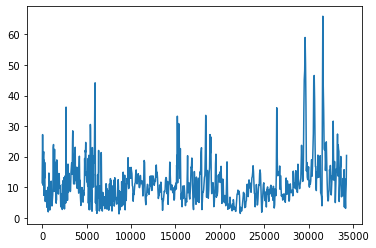

In [63]:
train_metadata[train_metadata['grid_id'] == '3S31A']['value'].plot()